## Plot Monsoon climatolofical daily cumulative sum of AIR region precipitation 

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import xarray as xr
import matplotlib.pyplot as mp
import pandas as pd
#import geocat.comp as gc
#import seaborn as sb
import scipy as sp

import numpy as np
import os
import glob as gb
import dask

from matplotlib.cm import get_cmap
from matplotlib.dates import DateFormatter,MonthLocator
from matplotlib import cm
from matplotlib.lines import Line2D

import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cf
from cartopy.io import shapereader
import geopandas

import warnings

#warnings.filterwarnings("ignore")
# Silence dask.distributed logs
import logging

#logger = logging.getLogger("distributed.utils_perf")
#logger.setLevel(logging.ERROR)

#import holoviews as hv
#import hvplot.pandas
#import hvplot.xarray
#import intake

import importlib


### To Import My Functions ###
import daily_annual_cycle_calc as myplt

import intake 
from distributed import Client
from ncar_jobqueue import NCARCluster

/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
#cluster = NCARCluster()
#cluster.scale(10)
#client = Client(cluster)
#client
cluster = NCARCluster(memory='25 GB', cores=1, walltime='06:00:00')
cluster.scale(19)
client = Client(cluster)
cluster



/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41649 instead
  warnings.warn(


In [4]:
'''
    SET UP CASE
'''

reg_name = 'India'
case_names = ['GPCP','AIR']
#case_names = ['TRMM','GPCP','E3SMv2','CESM2','CESM1']


var_name = 'PRECT' ; vscale = 86400.*1000.
years = ['1996','2005']
lpsave = True



# For the time/lat monsoon plot.
#lonm_w = 70 ; lonm_e = 100.
#latm_s = 0.; latm_n = 40. 

lonm_w = 70 ; lonm_e = 85.
latm_s = 10.; latm_n = 35. 

# Border of region for displayin map.
moffset = 10.

# Annual cycle options.
lat_lon = lonm_w,lonm_e,latm_s,latm_n



# Some run names
#crnums = ['001','002','003','004','005','006','007','008','009','010']
crnums = ['001','002','003','004','005','006']
#crnums = ['001']

ernums =  ['0101','0151','0201','0251','0301']
#ernums =  ['0101']

### TEMP PLOT ###



In [5]:
## Directories

dir_obs = '/glade/p/cesm/amwg/amwg_data/obs_data/'
dir_e3sm = '/glade/campaign/cgd/ccr/E3SMv2/FV_regridded/'
dir_cesm2 = '/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/'
dir_cesm1 = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily'
dir_o = '/glade/work/rneale/data/'


'''
    Ensmble set dic
'''

# Set ensebles set dic and df.

rset_dic = {}
rset_dic['E3SMv2'] = [dir_e3sm, ernums,'v2.FV1.historical_',years,'r','-',1.5]
rset_dic['CESM2'] =  [dir_cesm2,crnums,'b.e21.BHISTcmip6.f09_g17.LE2-1251.',years,'b','-',1.5]
rset_dic['CESM1'] =  [dir_cesm1,crnums,'b.e11.B20TRC5CNBDRD.f09_g16.',years,'g','-',1.5]
rset_dic['GPCP'] =  [dir_o,[''],'GPCP',years,'k','--',4]
rset_dic['TRMM'] =  [dir_o,[''],'TRMM',["2000","2009"],'k',':',4]
rset_dic['AIR'] =  [dir_o,[''],'AIR',years,'k','-.',4]



#Dataframe
rset_df = pd.DataFrame.from_dict(rset_dic, orient='index',
            columns=['ens_dir','ens_rnums','ens_pref','ens_years','p_linecol','p_ldash','p_lthick'])

leg_cols = rset_df.loc[case_names]['p_linecol'] 
leg_dash = rset_df.loc[case_names]['p_ldash'] 
#leg_lwidth =  rset_df.loc[case_names]['p_lthick']                  
leg_lines = [Line2D([0], [0], color=col, linewidth=4, linestyle=leg_dash[ic]) for ic,col in enumerate(leg_cols)]


'''
    Variable dic.     
'''

var_dic = {}
var_dic['PRECT'] = (vscale,lat_lon,['GPCP','TRMM','AIR'],['PREC','PRECT',''],[1.,1.,1.])
                          
# Dataframe                                                    
var_df = pd.DataFrame.from_dict(var_dic, orient='index', columns=['vscale','lon_lat','osource','onames','oscale'])                 



/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/feature/__init__.py:217: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  self._geoms = tuple(geometries)
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/feature/__init__.py:217: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  self._geoms = tuple(geometries)


 ---------- Variable = PRECT -----------

**************************************************************
* Ensemble set # 1  ( GPCP ) -  1  ensemble simulations
* Asking for years  1996  to  2005
**************************************************************
GPCP  -  1  ensemble members

- Ensemble run #  1
-- return_common_loc -- : Grabbing typical run path for GPCP
/glade/work/rneale/data//GPCP/GPCP_1DD_v1.2_199610-201407.nc
['/glade/work/rneale/data//GPCP/GPCP_1DD_v1.2_199610-201407.nc']
-Dataset year Range =  <bound method ImplementsArrayReduce._reduce_method.<locals>.wrapped_func of <xarray.DataArray 'time' (time: 6513)>
array(['1996-10-01T12:00:00.000000000', '1996-10-02T12:00:00.000000000',
       '1996-10-03T12:00:00.000000000', ..., '2014-07-29T12:00:00.000000000',
       '2014-07-30T12:00:00.000000000', '2014-07-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1996-10-01T12:00:00 ... 2014-07-31T12:00:00
Attributes:
    lon

AttributeError: 'numpy.ndarray' object has no attribute 'where'

NameError: name 'var_data' is not defined


**************************************************************
* Ensemble set # 2  ( AIR ) -  1  ensemble simulations
* Asking for years  1996  to  2005
**************************************************************
AIR  -  1  ensemble members

- Ensemble run #  1
-- return_common_loc -- : Grabbing typical run path for AIR
/glade/work/rneale/data//AIR/AIR_daily_climatology.dat
['/glade/work/rneale/data//AIR/AIR_daily_climatology.dat']
-Dataset year Range = 19XX to 20XX

CPU times: user 2.89 ms, sys: 1.99 ms, total: 4.88 ms
Wall time: 5.13 ms
CPU times: user 1.6 ms, sys: 0 ns, total: 1.6 ms
Wall time: 1.55 ms


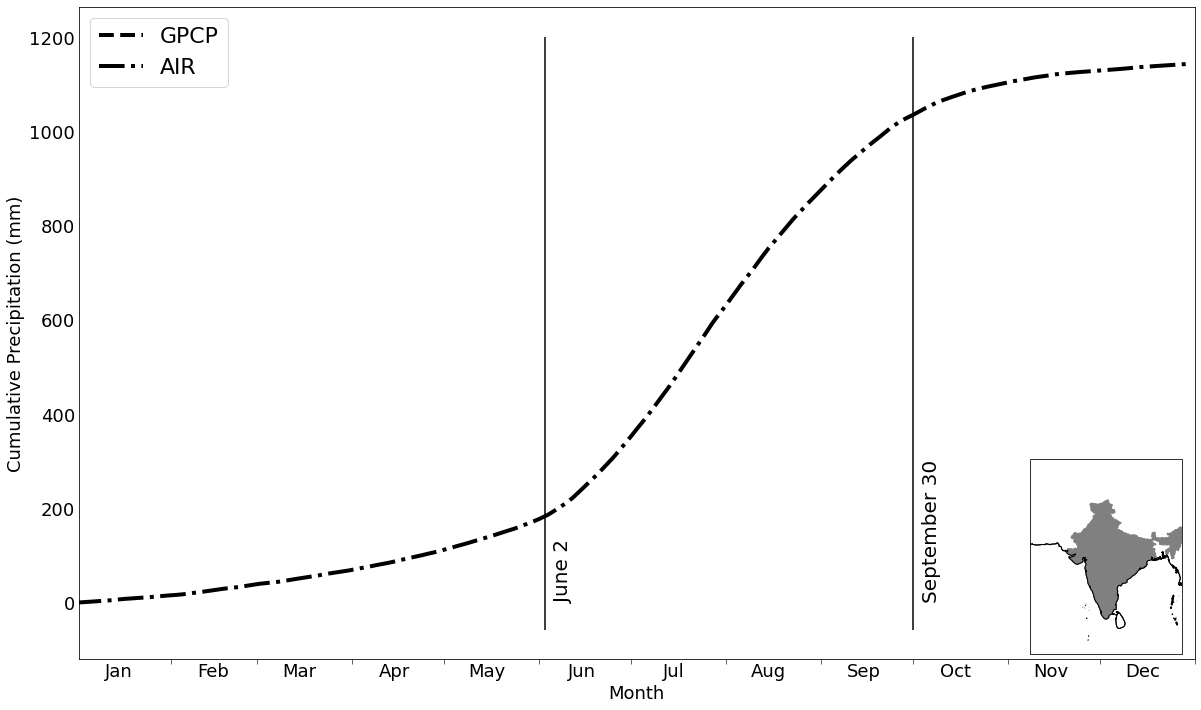

In [8]:
importlib.reload(myplt) # Required because I am constantly editing scam_func.py

fig, ax = mp.subplots(figsize=(20,12))
#ax = fig.add_axes([0.15,0.35,0.15,0.2],)
axins = myplt.region_mask(ax,lat_lon,lmask=True)

land_10m = NaturalEarthFeature('physical', 'land', '10m')
print(land_10m)

print(' ---------- Variable = '+var_name+' -----------')

for icase,cname in enumerate(case_names):
    
    nens = len(rset_df.loc[cname]['ens_rnums']) # Num. Ensmble simulations
    
    print('')
    print('**************************************************************')
    print('* Ensemble set #',icase+1,' (',cname,') - ',nens,' ensemble simulations')
    print('* Asking for years ',years[0],' to ',years[1])
    print('**************************************************************')
          
    rset = rset_df.loc[cname]   
    
        
    '''
        Routine for reading in data and calculating annual cycle from daily data
    '''
    
    %time var_data = myplt.calc_daily_acycle(reg_name,cname,rset_df,var_df) # rest dic and ens index   
    
         
    '''
        Line plotting 
    '''
    
    linecol = rset_df.loc[cname]['p_linecol']    
    ldash = rset_df.loc[cname]['p_ldash']    
    lthick = rset_df.loc[cname]['p_lthick']    
    porder = 5 if cname in var_df.loc[var_name]['osource'] else 1
    
    %time for iens in range(0,nens) : ax.plot(var_data[iens,:],color=linecol,linestyle=ldash,linewidth=lthick,zorder=porder)
    
    
    
'''
    Set Axes And Legend
'''

date_form = DateFormatter("%b")
ax.xaxis.set_major_locator(MonthLocator(bymonthday=15))
ax.xaxis.set_minor_locator(MonthLocator())
ax.xaxis.set_major_formatter(date_form)

ax.set_xlim([1,365]) 
yr = ax.get_ylim()
ax.vlines(153, yr[0], yr[1], color='black', linestyle='-') # Jun 2
ax.vlines(273, yr[0], yr[1], color='black', linestyle='-') # Spe 30

ax.text(156, 0, "June 2", rotation=90, verticalalignment='bottom',fontsize=20)
ax.text(276, 0, "September 30", rotation=90, verticalalignment='bottom',fontsize=20)

ax.tick_params(which='major', length=0)
ax.tick_params(which='minor', length=5)
ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Cumulative Precipitation (mm)', fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)




ax.legend(leg_lines, case_names,loc='upper left',fontsize=22)
mp.savefig('daily_prec_as_AIR_cesm_e3sm_test.png', dpi=100)  
    